# P-median model


Decision variables
- Whether or not to have a hospital at location $j$, $X_j$
- Whether or not to allocate customer $i$ to hospital at $j$, $Y_{ij}$

Constraints
- You can only allocate to hospitals that exist
$\forall i,j Y_{ij} \leq X_j$, alternatively $\forall j \sum_i^m Y_{ij} \leq m X_j$ 
- Each person needs to be allocated to one hospital $\forall i \sum_j^n Y_{ij} = 1$
- Need to locate exactly $p$ hospitals $\sum_j X_j = p$

Objective function
- Minimize the sum of $Y_{ij} cost(i,j)$, the sum of all the costs to reach hospital $j$ from location $i$

Note:
- The entire constraint matrix is only dependent on $p$, $n$, and $m$, the only part that actually depends on the actual lat/long locations is the objective function
- So I should write something that generates the entire constraint matrix given the constants

In [1]:
import numpy as np
from scipy.optimize import linprog

In [2]:
def p_median_constraint_matrix(num_hospitals, num_patients, num_locations):
    # n = num_locations
    # p = num_hospitals
    # m = num_patients
    # layout of decision vector
    # lentgh = n + n*m
    # first n entries -> binary, whether or not a hospital is located at location j
    # next n entries -> binary, which hospital is this patient allocated to, only one should be equal to one
    # ^ one of those sets for each patient, total = m
    vec_size = num_locations + num_locations * num_patients

    # number of constraints
    # leq constraints 
    # n constraints for the first set

    # equality constraints
    # m constraints for the second set
    # one constraint for the last set

    A_leq = np.empty((num_locations, vec_size))
    b_leq = np.empty(num_locations)

    A_eq = np.empty((num_patients + 1, vec_size))
    b_eq = np.empty(num_patients + 1)

    # first set of constraints -> all patients must be allocated to hospitals that exist
    # attempting to do the smaller constraint set to improve performance (yes i know premature optimization yada yada whatever it should be fine)
    constraint_leq_num = 0
    for j in range(num_locations):
        row = np.zeros(vec_size)
        indexes = np.array(range(vec_size))
        row[indexes % num_locations == j] = 1
        row[j] = -num_patients
        A_leq[constraint_leq_num:] = row
        b_leq[constraint_leq_num] = 0
        constraint_leq_num += 1

    # second set of constraints -> everyone is allocated to one hospital
    constraint_eq_num = 0
    for i in range(num_patients):
        row = np.zeros(vec_size)
        indexes = np.array(range(vec_size))
        row[indexes // num_locations == i + 1] = 1
        A_eq[constraint_eq_num:] = row
        b_eq[constraint_eq_num] = 1
        constraint_eq_num += 1

    # third constraint -> exactly p hospitals are allocated
    row = np.zeros(vec_size)
    indexes = np.array(range(vec_size))
    row[indexes < num_locations] = 1
    A_eq[-1:] = row
    b_eq[-1:] = num_hospitals

    bounds = np.array([(0, 1) for _ in range(vec_size)])
    integrality = np.ones(vec_size)
    return A_leq, b_leq, A_eq, b_eq, bounds, integrality

In [3]:
def p_median_objective_function(distances):
    _, num_locations = np.shape(distances)
    return np.append(np.zeros(num_locations), np.ndarray.flatten(distances))

In [24]:
def p_median_interpret_solution(solution, num_hospitals, num_patients, num_locations, output=True):
    solution_x = np.array([round(v) for v in solution.x])
    if solution.status != 0 and output:
        print(f"linprog failed: {solution.status}")
    mistakes = 0
    choices = np.array(range(num_locations))[solution_x[:num_locations] == 1]
    if output:
        print(f"Solution allocates hospitals at: {choices}")
    if len(choices) != num_hospitals:
        if output:
            print(f"!! Failed to allocate the right number of hospitals! | Allocated {len(choices)} out of {num_hospitals}")
        mistakes += 1

    vec_size = num_locations + num_locations * num_patients
    for i in range(num_patients):
        indexes = np.array(range(vec_size))
        patient_allocation = solution_x[indexes // num_locations == i + 1]
        choice = np.array(range(num_locations))[patient_allocation == 1]
        if output:
            print(f"Patient #{i} => {choice}")
        if len(choice) != 1:
            if output:
                print(f"!! Failed to properly allocate patient #{i}")
            mistakes += 1
            continue
        if not choice[0] in choices:
            if output:
                print(f"Allocated patient #{i} to a location that does not exist ({choice})")
            mistakes += 1
            continue
    if mistakes > 0:
        print("MISTAKES FOUND!!!")
        return mistakes
    return choices

In [5]:
A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=1, num_patients=2, num_locations=3)

# two patients, A prefers location 1, B prefers location 2 but is ok with location 1
# location 1 should get allocated
distances = np.array([[1, 5, 7], [3, 1, 7]])
c = p_median_objective_function(distances)

In [6]:
solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
solution.x
p_median_interpret_solution(solution, 1, 2, 3)

Solution allocates hospitals at: [0]
Patient #0 => [0]
Patient #1 => [0]


0

In [52]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/mnt/h/Documents/fifth_year_shit/math441/project/utils.py'>

69
[(49.24982799999999, -123.125774), (49.249826162933054, -123.10517105577243), (49.249826162933054, -123.14637694422758), (49.24982065173277, -123.08456811460267), (49.24982065173277, -123.16697988539734), (49.24981146640064, -123.06396517954852), (49.24981146640064, -123.1875828204515), (49.249798606939216, -123.04336225366778), (49.249798606939216, -123.20818574633223), (49.24978207335204, -123.02275934001823)]


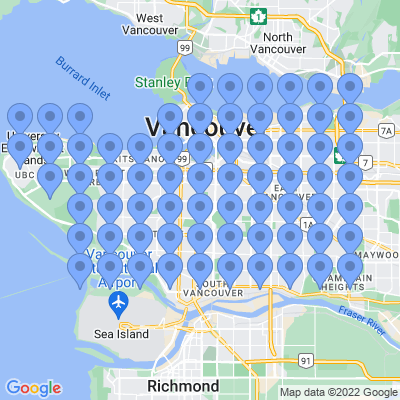

In [34]:
test_problem_center = (49.249828, -123.125774)
test_problem_top_left = (49.295863, -123.270310)
test_problem_bottom_right = (49.196127, -123.021401)
# test_problem_bottom_right = (49.119850, -122.799905)
test_problem_points = utils.equidistant_points(test_problem_center, test_problem_top_left, test_problem_bottom_right, height=20, width=20, unit=1.5)
test_problem_points = list(filter(utils.is_on_land, test_problem_points))
print(len(test_problem_points))
print(test_problem_points[:10])
display(utils.get_map(test_problem_center, markers=[("blue", test_problem_points)], zoom=11))
distances = utils.straight_line_distance_matrix(test_problem_points, test_problem_points)

Hospitals = 1 | Choices = [0] | Cost (avg distance in km)= 5.118056283437807


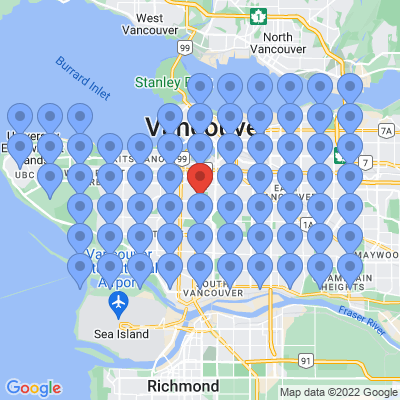

Hospitals = 2 | Choices = [4 5] | Cost (avg distance in km)= 3.50125482123748


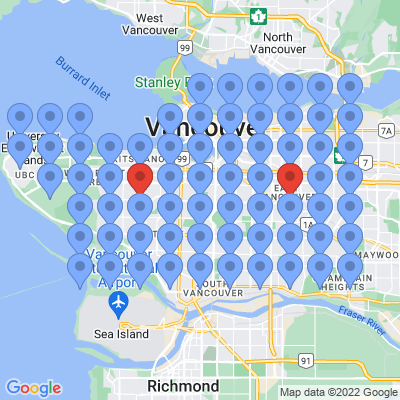

Hospitals = 3 | Choices = [ 6 40 42] | Cost (avg distance in km)= 2.930294478356253


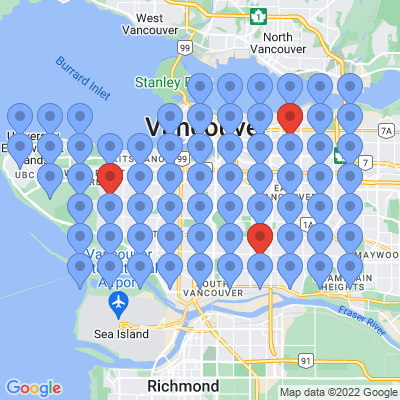

Hospitals = 4 | Choices = [ 8 27 38 39] | Cost (avg distance in km)= 2.5124638949091778


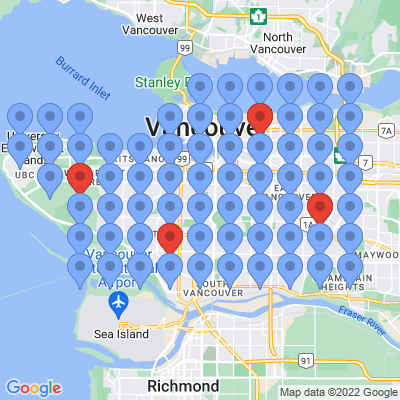

Hospitals = 5 | Choices = [11 26 41 43 45] | Cost (avg distance in km)= 2.1623216229096


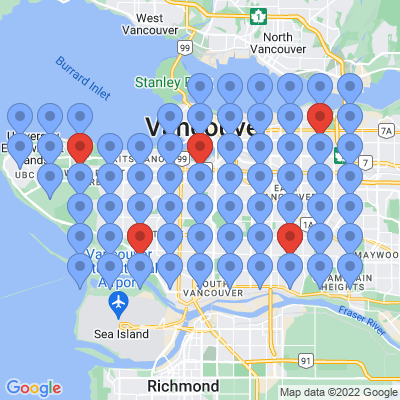

Hospitals = 6 | Choices = [11 30 34 43 44 45] | Cost (avg distance in km)= 1.9604212238705105


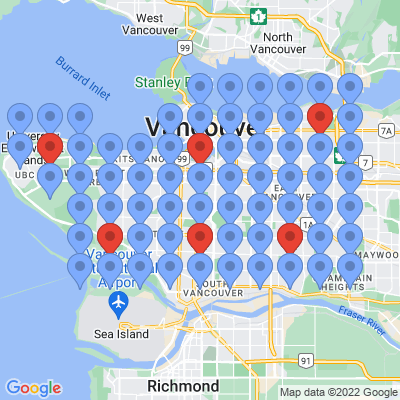

Hospitals = 7 | Choices = [ 4 27 30 35 37 44 45] | Cost (avg distance in km)= 1.7891217239100883


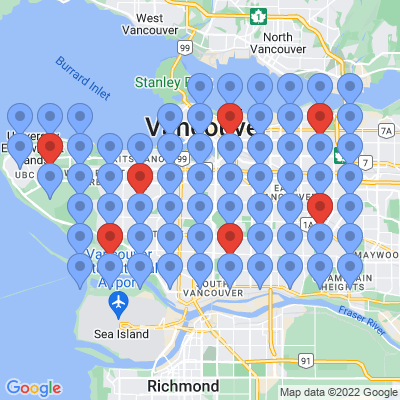

Hospitals = 8 | Choices = [18 19 30 34 35 44 45 47] | Cost (avg distance in km)= 1.6522958591236137


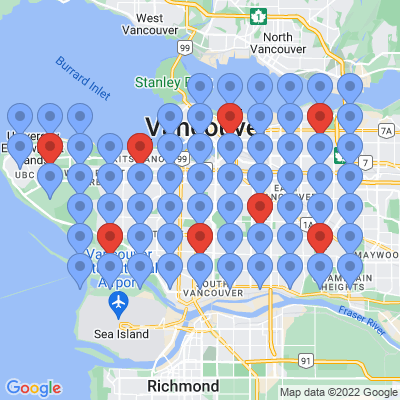

Hospitals = 9 | Choices = [ 1 18 27 30 34 44 45 55 62] | Cost (avg distance in km)= 1.5602074694981256


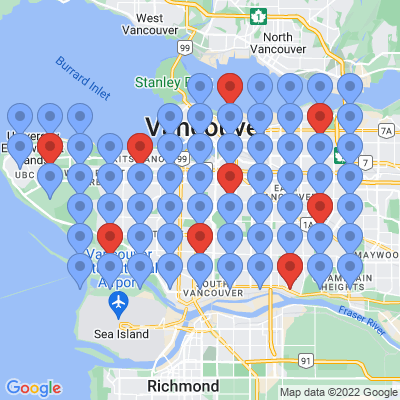

In [31]:
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    num_patients = len(test_problem_points)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    display(utils.display_solution(test_problem_center, test_problem_points, choices, show_coverage=False))
    # break

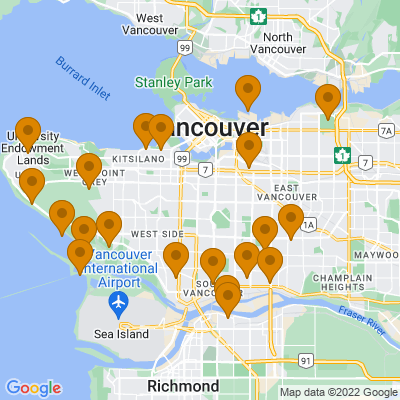

Avg dist (from samples) = 1.686850986547877


In [54]:
# 9 hospital solution
hospitals = [test_problem_points[i] for i in choices]
result, samples = utils.uniform_random_evaluate_solution(hospitals)
display(utils.get_map(test_problem_center, markers=[("orange", samples[:20])], zoom=11))
print(f"Avg dist (from samples) = {result}" )